# Exploring github collaboration

## Preface

Github is home to many collaborative and open source projects. It is accessible to anyone across skill levels, and provides a platform for collaoration to happen in a public manner (ie. source code is displayed, and any updates are documented and accessible by the public as long as the repository is a public one). 

On top of that, github has provided an API for accessing site data (documentation [here](https://developer.github.com/v3/)), allowing us to access data on repositories, users, code commits etc.

Given the wealth of information available, the natural question (to me) is: an we then build a "social network" of projects hosted on github? Through that, can we then gather insights towards how people collaborate, visualise what collaboration looks like and understand how "successful" projects are created/ managed? 

** How is this useful?**
By analysing how people contribute and collaborate, we can then extract features which inform us on how to manage projects succesfully. Relatedly, what are the aspects of open-source collaboration which started well, but then fizzled out, and what are the potential pitfalls which can (retrospectively at least) be avoided?

### Interesting resources
- [Github API documentation](https://developer.github.com/v3/)
- Python wrapper for Githun api [PyGithub](http://pygithub.readthedocs.io/en/latest/index.html)
- Paper: [Github as a Collaborative Social Network (Lima et al., 2014)](https://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/download/8112/8130)
- Interactive network visualiser using D3 [Github visualizer (artzub)](http://ghv.artzub.com/)

### General aim of this exploration

**Using the Github API, explore how projects are connected via their contributors**
Towards this aim, I will first explore the network around projects which I am familiar, then build up into a deeper exploration of constructing social networks within the github community.

### Specific outline
Exploring collaboration on github using 3 small examples: 

- Looking just at the tensorflow repository, who are the top contributors and how do they work? Is there a relationship between code deletions and additions?
    + produce matplotlib visualisations of how the top 3 contributors of tensorflow make commits, additions and deletions to to the repository 
- Do the contributors to tensorflow also contribute to other deep-learning/ neural network repositories? Do collaborations happen mainly within the tensorflow organisation, or do they also contribute to other projects outside of the organisation?
    + Produce network graphs connecting the users to each repository
    + Examine some summary statistics of this graph using the networkx library
- Instead of the directed approach in example 2, can we apply the same analysis to topics within github?
    + Produce network graphs connecting the users to each repository
- Next steps: planning the continuation of the project + timeline of deliverables

## Example 1: Building a  simple network around tensorflow
Tensorflow is one of the most popular neural network and deep learning libraries hosted on github. I chose to start with tensorflow because of genuine curiosity on how this project waas developed, and also because I know that there are several libries like tensorboard and keras which integrate well/wrap around (during use) tensorflow. Exploring these aspects through github data can potentially reveal how people work together to produce the functionalities of projects. 

##### workflow
- Extrating tensorflow repository data from the github API using PyGithub
- Exploring the user contributions to tensorflow

In [1]:
from github import Github # import PyGithub
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

with open('keys.txt') as keys: # file with user details 
    details = [line.split('\n')[0] for line in keys]    
    keys.close
    
g = Github(details[0], details[1]) # access github via login details

In [2]:
tf = g.search_repositories('tensorflow', sort = 'stars', order = 'desc') #find the tensorflow repository
tf[0].name

'tensorflow'

In [3]:
contri = tf[0].get_contributors() # contributor data
''' 
list of contributors who have made more than 10 contributions to tf
only including named contributors for now'''
cont_list = [c.name for c in contri if c.contributions > 10 and c.name != None]
len(cont_list) # 168 contributors made the list 

177

In [9]:
top_tf_contributor = cont_list[0]
second_tf_contributor = cont_list[1] #
print('top:', top_tf_contributor, 'second:', second_tf_contributor)

top: TensorFlower Gardener second: Shanqing Cai


In [63]:
## let's take a closer look at the top ten contributors
stats_cont = tf[0].get_stats_contributors()
stats_cont_totals = {'login':[], 'total_cont':[] }
stats_cont_deletions = {}
stats_cont_additions = {}
stats_cont_commits = {}
stats_cont_week = {}

for c in range(len(stats_cont)):
    if stats_cont[c].total > 10:
        stats_cont_totals['login'].append(stats_cont[c].author.login) 
        stats_cont_totals['total_cont'].append(stats_cont[c].total)
        stats_cont_deletions[stats_cont[c].author.login] = [stats_cont[c].weeks[i].d for i in range(len(stats_cont[c].weeks))]
        stats_cont_additions[stats_cont[c].author.login] = [stats_cont[c].weeks[i].a for i in range(len(stats_cont[c].weeks))]
        stats_cont_commits[stats_cont[c].author.login] = [stats_cont[c].weeks[i].c for i in range(len(stats_cont[c].weeks))]
        stats_cont_week[stats_cont[c].author.login] = [stats_cont[c].weeks[i].w for i in range(len(stats_cont[c].weeks))]


In [65]:
totals = pd.DataFrame.from_dict(stats_cont_totals)

<BarContainer object of 10 artists>

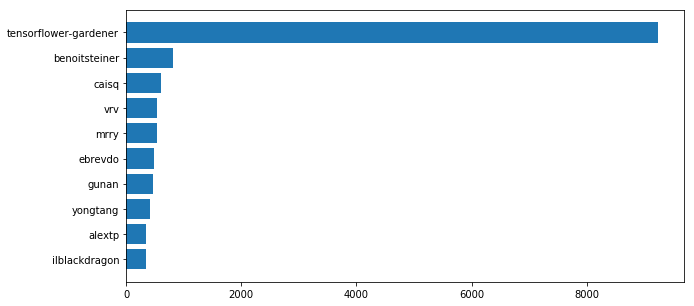

In [81]:
# plot total contribution of top ten contributors
fig, ax = plt.subplots(figsize = (10,5))
ax.barh(totals['login'][-10:], totals['total_cont'][-10:] )

In [136]:
# lets look the activity of top 3 contributors over time
commits = pd.DataFrame.from_dict(stats_cont_commits)
deletions = pd.DataFrame.from_dict(stats_cont_deletions)
additions = pd.DataFrame.from_dict(stats_cont_additions)
weeks= pd.DataFrame.from_dict(stats_cont_week)

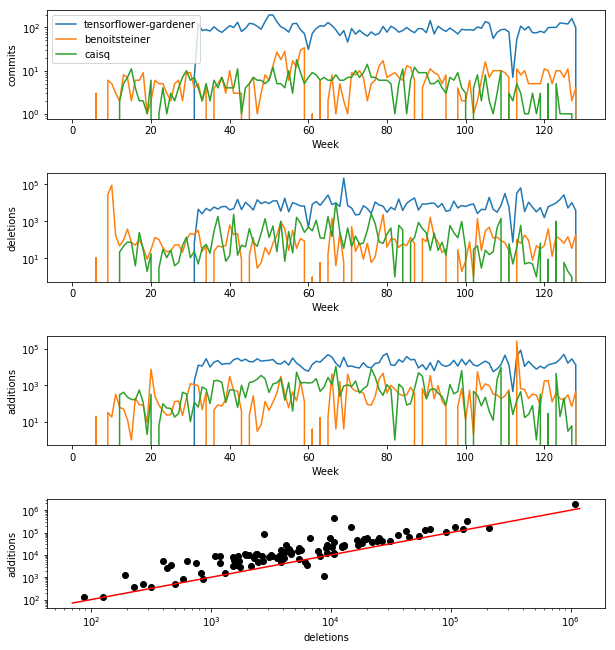

In [139]:
# plot activity over time
top_3_users = totals['login'][-3:].tolist()
fig,ax = plt.subplots(nrows=4, figsize = (10,11))

ax[0].plot(commits[top_3_users[2]])
ax[1].plot(deletions[top_3_users[2]])
ax[2].plot(additions[top_3_users[2]])

ax[0].plot(commits[top_3_users[1]])
ax[1].plot(deletions[top_3_users[1]])
ax[2].plot(additions[top_3_users[1]])

ax[0].plot(commits[top_3_users[0]])
ax[1].plot(deletions[top_3_users[0]])
ax[2].plot(additions[top_3_users[0]])

#sum all deletions and addtions for each user, what is the relationship between code addition and deletion?
del_sum = deletions.sum(axis = 0)
add_sum = additions.sum(axis = 0)

ax[3].scatter(del_sum,add_sum, color = 'black') # remove tensorflower-gardener
ax[3].plot([70,1190000],[70,1190000], color = 'red')
# set labels 
ax[0].set_ylabel('commits')
ax[1].set_ylabel('deletions')
ax[2].set_ylabel('additions')
ax[0].set_xlabel('Week')
ax[1].set_xlabel('Week')
ax[2].set_xlabel('Week')
ax[3].set_ylabel('additions')
ax[3].set_xlabel('deletions')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')
ax[3].set_xscale('log')
ax[0].legend()
# increase height between subplots
fig.subplots_adjust(hspace = 0.5)

#### plot summary

It appears that the top contributor, 'tensorflower-gardener' is the most consistent with commits, additions and deletions, while also largely producing an order more output to other individual users overall. My verdict here is that 'tensorflower-gardener' is most likely a bot (also because I am aware of the existance of automated repository managers). 

The next two top contributors are much more 'human', with more breaks and variation in output. They alwo appear to have much the same output over time, although 'benoitsteiner' does appear to have more breaks inbetween each spurt of contribution (perhaps suggesting that some proportion of time might be spent on other projects?). 

The final subplot shows the sum of code addition and deletion for each of the top 100 contributors, and a red line indicating where deletions == additions. This one is most interesting, since most users tend to make more additions thatn deletions, with the exception of about 5 users.

## Example 2: how are commonly associated repositories connected?

Now that some of the contributor data related to the tensorflow repository have been explored, the natural progression is to look at other projects within the tensorflow organisation, and commonly associated repositories and start to build a network

- Tensorboard (internal)
- Models (internal)
- pytorch (external)
- Keras (external, but integrated)
- tfjs-core (internal, different language) 

Why only look at contributors, not forks of repositories? As [(Lima et al., 2014)](https://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/download/8112/8130) showed, a vast majority of forks do not form active contributions, as people are likely to just fork an repo without making any change to them. As an example, tensorflow has (at the time of writing) 61,821 forks!! While only  having a total of 1445 contributors. 

In [3]:
tb = g.search_repositories('tensorflow/tensorboard', sort = 'stars', order = 'desc') #tensorboard repository
mo = g.search_repositories('tensorflow/models', sort = 'stars', order = 'desc') #tensorflow models repository
pt = g.search_repositories('pytorch', sort = 'stars', order = 'desc') #pytorch repository
kr = g.search_repositories('keras', sort = 'stars', order = 'desc') #keras repo
tj = g.search_repositories('tensorflow/tfjs-core', sort = 'stars', order = 'desc') #tfjs-core repo

In [13]:
import networkx as nx
from itertools import combinations 
from itertools import count

In [7]:
# function to output dict for networkx
## consider size of repo (by number of contributors), names of contributors, repo name, 

G = nx.Graph() # total graph
U = nx.Graph() # user graph
R = nx.MultiGraph() # repo graph

def repo_to_network(repo):
    cont = repo.get_contributors()
    cont_name = [c.login for c in cont if c.contributions > 20]
    cont_num = [c.contributions for c in cont if c.contributions> 20]
    cont_comp = [c.company for c in cont if c.contributions > 20]
    
    G.add_node(repo.name, node_type = 'project', reponame= repo.name, num_contributors= len(cont_name), language= repo.language)
    R.add_node(repo.name, node_type = 'project', reponame= repo.name, num_contributors= len(cont_name), language= repo.language)
    for c in range(len(cont_name)):
        G.add_node(cont_name[c], node_type = 'user', company= cont_comp[c], num_contributions=cont_num[c]) # add nodes
        G.add_edge(cont_name[c], repo.name) # add edge from user to repo
        R.add_edge(cont_name[c], repo.name)
        U.add_node(cont_name[c], node_type = 'user', company= cont_comp[c], num_contributions=cont_num[c])
    U.add_edges_from(combinations(cont_name,2))
     

In [8]:
repo_to_network(tf[0])

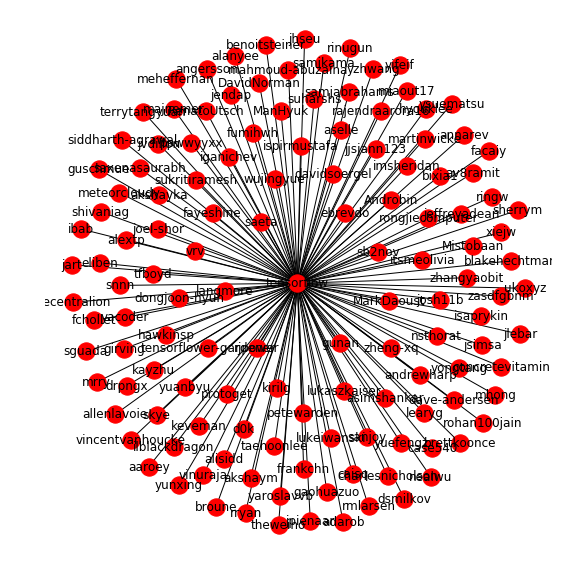

In [9]:
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
nx.draw(G, with_labels = True)

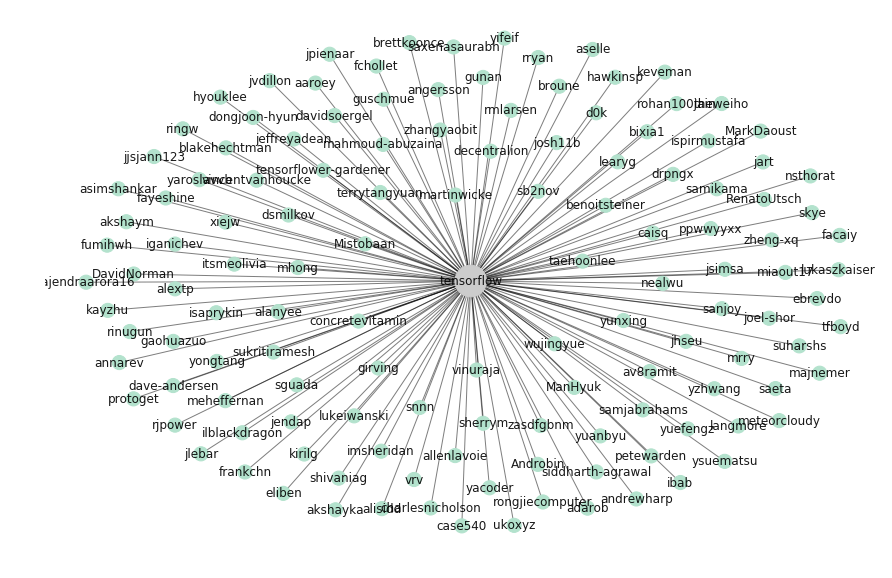

In [10]:
# different colormap for projects and users
groups = set(nx.get_node_attributes(G,'node_type').values())
mapping = dict(zip(groups, [1000,200]))
nodes = G.nodes()
colors = [mapping[G.node[n]['node_type']] for n in nodes]



# drawing nodes and edges separately so we can capture collection for colobar
fig = plt.figure(figsize = (15,10))
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.5)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, 
                            label=True, node_size=colors, cmap=plt.cm.Pastel2)
lc = nx.draw_networkx_labels(G, pos, alpha = 0.9)
plt.axis('off')
plt.show()

#### Incrementally building a network

In [11]:
repo_to_network(tb[0]) # add tensorboard to network

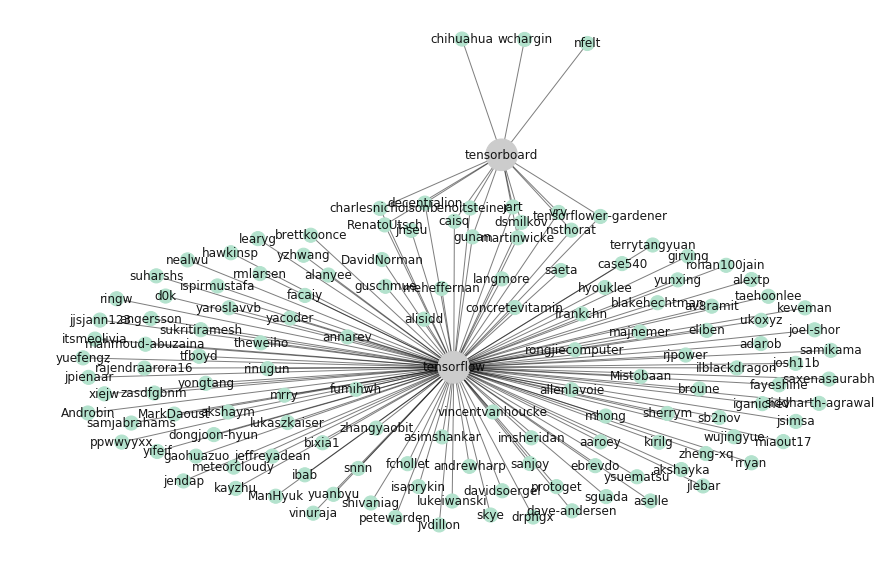

In [12]:
groups = set(nx.get_node_attributes(G,'node_type').values())
mapping = dict(zip(groups, [1000,200]))
nodes = G.nodes()
colors = [mapping[G.node[n]['node_type']] for n in nodes]



# drawing nodes and edges separately so we can capture collection for colobar
fig = plt.figure(figsize = (15,10))
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.5)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, 
                            label=True, node_size=colors, cmap=plt.cm.Pastel2)
lc = nx.draw_networkx_labels(G, pos, alpha = 0.9)
plt.axis('off')
plt.show()

In [13]:
repo_to_network(mo[0])

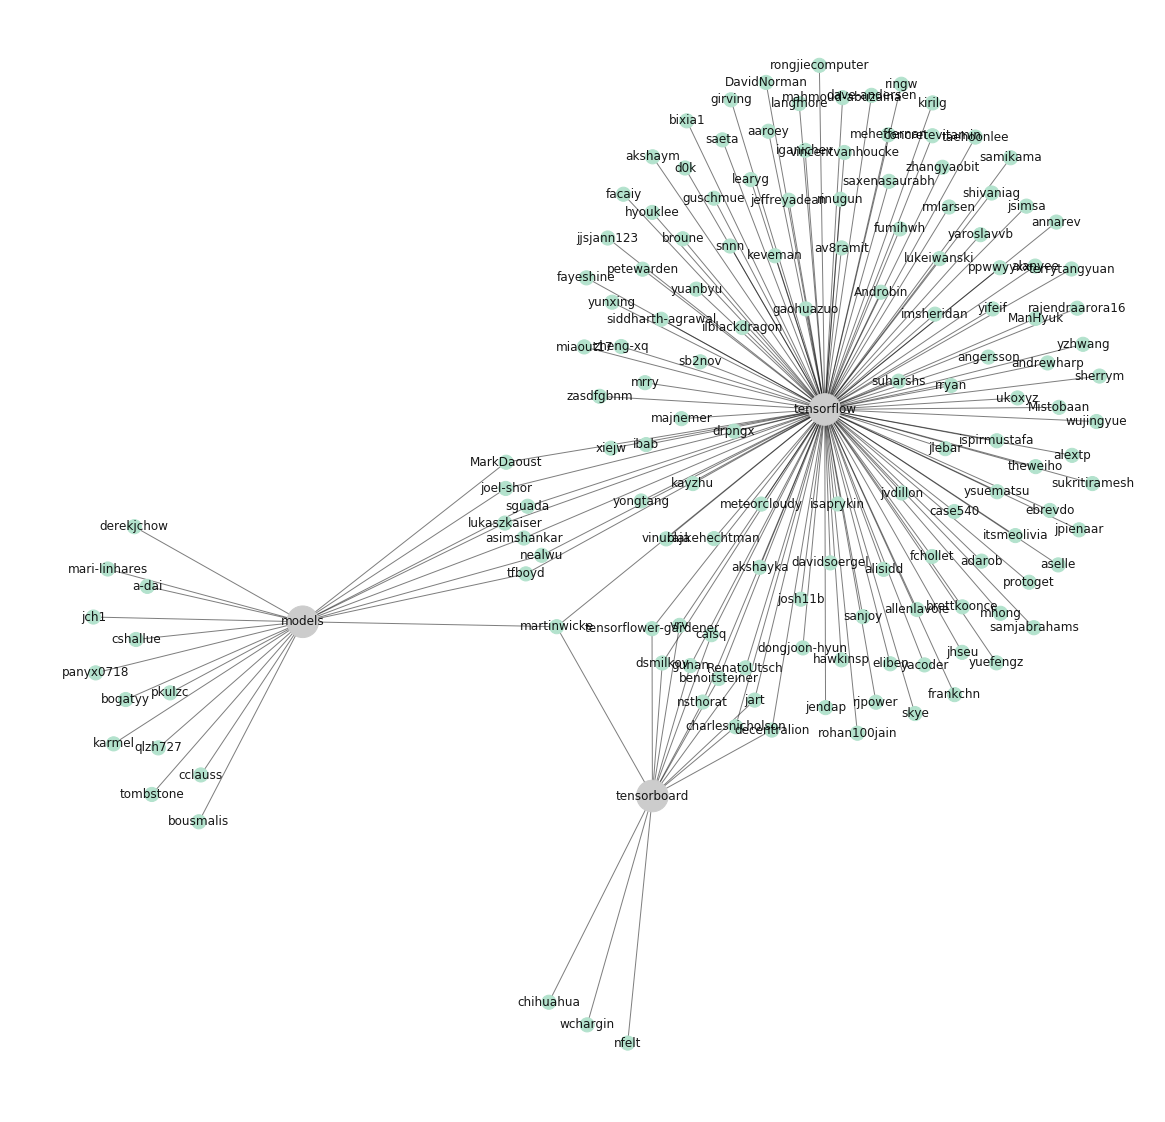

In [15]:
groups = set(nx.get_node_attributes(G,'node_type').values())
mapping = dict(zip(groups, [1000,200]))
nodes = G.nodes()
colors = [mapping[G.node[n]['node_type']] for n in nodes]



# drawing nodes and edges separately so we can capture collection for colobar
fig = plt.figure(figsize = (20,20))
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.5)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, 
                            label=True, node_size=colors, cmap=plt.cm.Pastel2)
lc = nx.draw_networkx_labels(G, pos, alpha = 0.9)
plt.axis('off')
plt.show()

In [16]:
repo_to_network(kr[0])

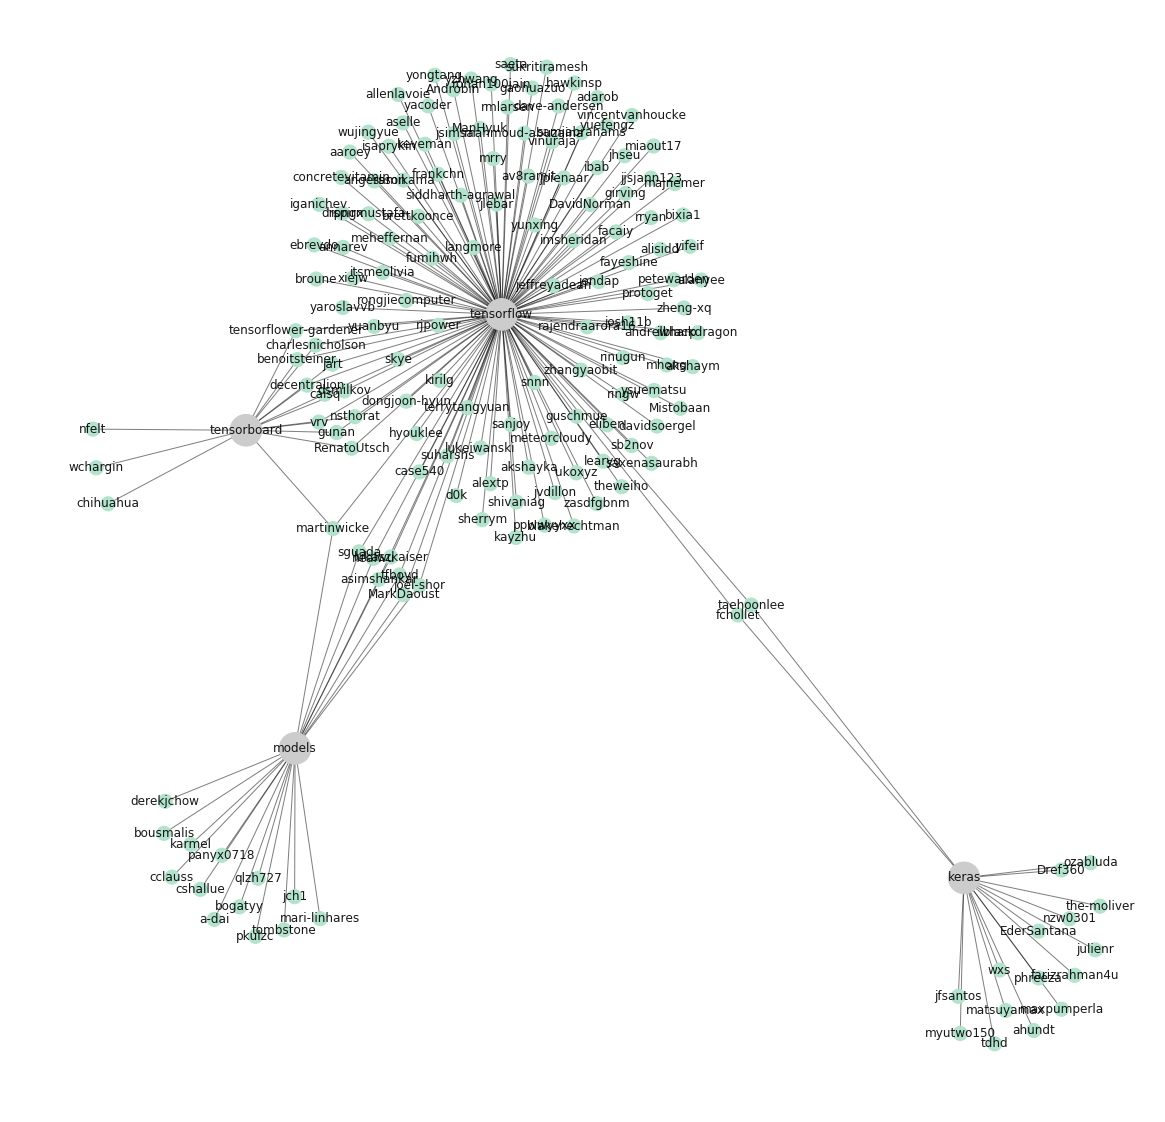

In [17]:
groups = set(nx.get_node_attributes(G,'node_type').values())
mapping = dict(zip(groups, [1000,200]))
nodes = G.nodes()
colors = [mapping[G.node[n]['node_type']] for n in nodes]



# drawing nodes and edges separately so we can capture collection for colobar
fig = plt.figure(figsize = (20,20))
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.5)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, 
                            label=True, node_size=colors, cmap=plt.cm.Pastel2)
lc = nx.draw_networkx_labels(G, pos, alpha = 0.9)
plt.axis('off')
plt.show()

In [18]:
repo_to_network(tj[0])

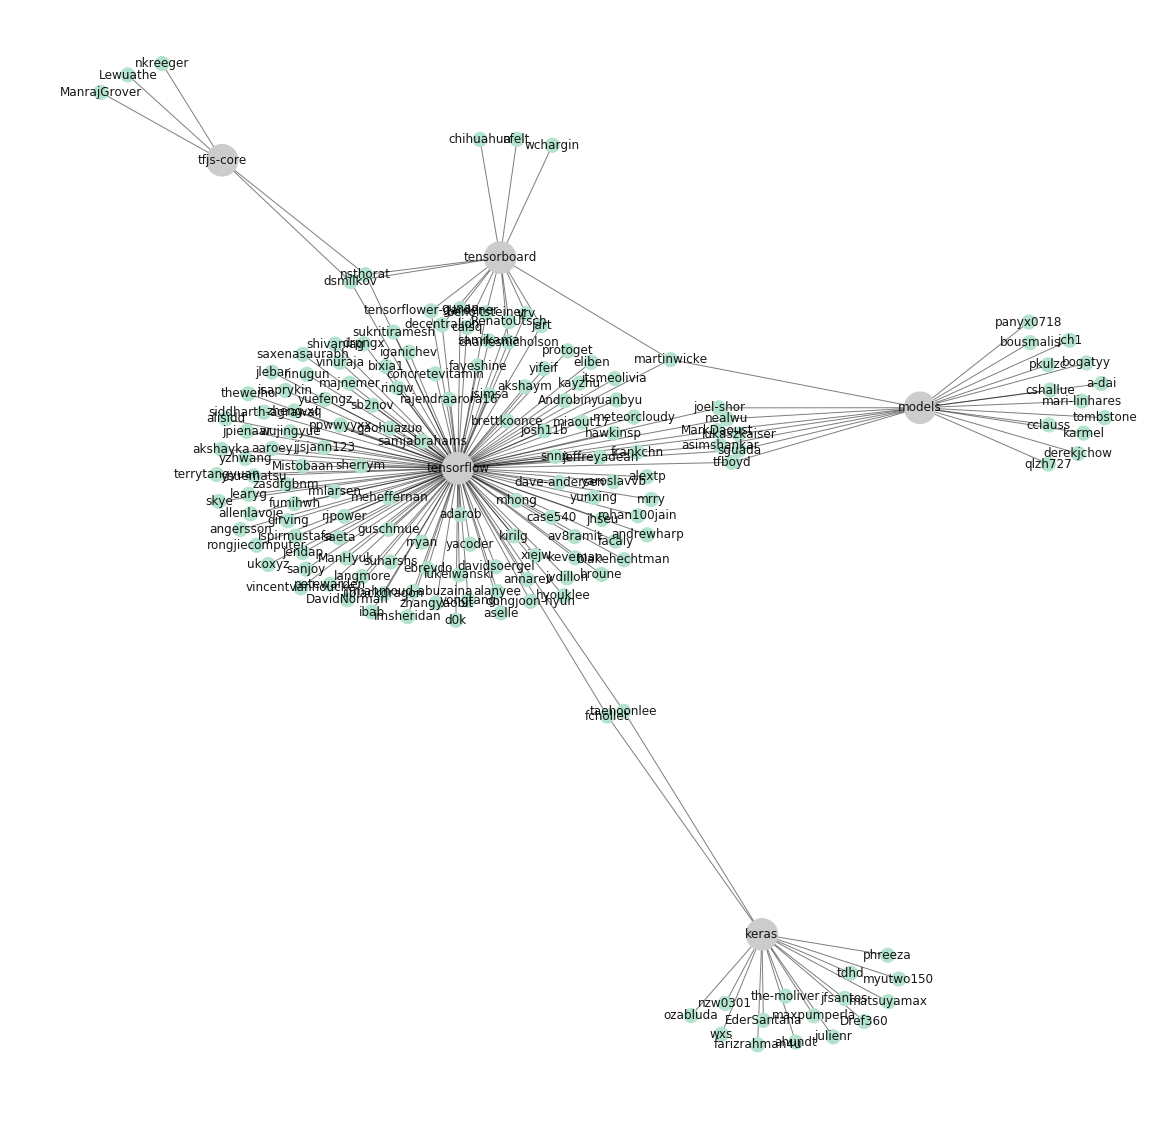

In [19]:
groups = set(nx.get_node_attributes(G,'node_type').values())
mapping = dict(zip(groups, [1000,200]))
nodes = G.nodes()
colors = [mapping[G.node[n]['node_type']] for n in nodes]



# drawing nodes and edges separately so we can capture collection for colobar
fig = plt.figure(figsize = (20,20))
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.5)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, 
                            label=True, node_size=colors, cmap=plt.cm.Pastel2)
lc = nx.draw_networkx_labels(G, pos, alpha = 0.9)
#plt.colorbar(nc)
plt.axis('off')
plt.show()

In [20]:
repo_to_network(pt[0])

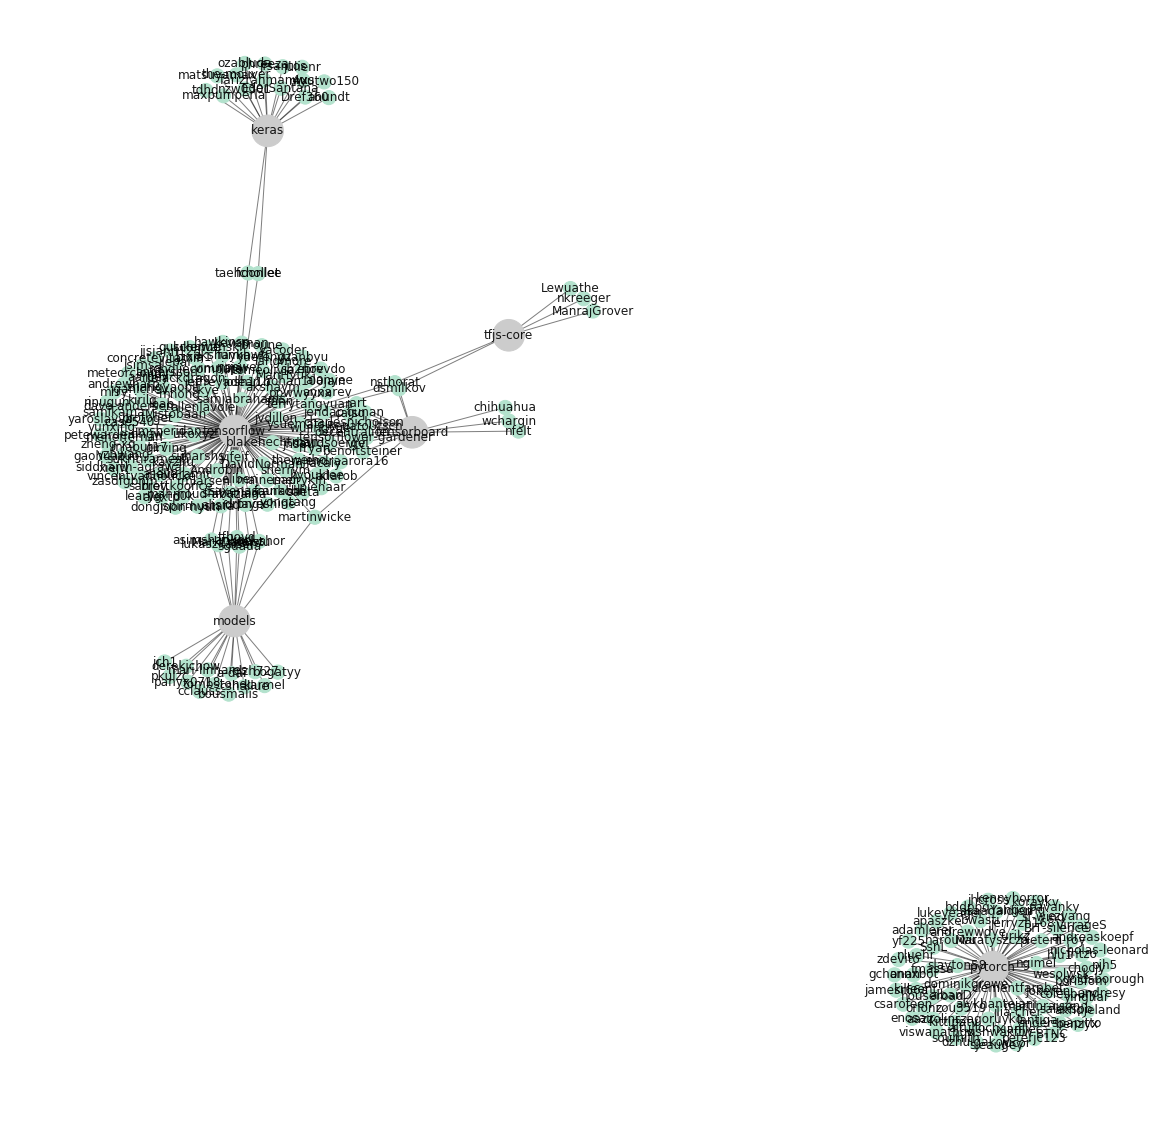

In [21]:
groups = set(nx.get_node_attributes(G,'node_type').values())
mapping = dict(zip(groups, [1000,200]))
nodes = G.nodes()
colors = [mapping[G.node[n]['node_type']] for n in nodes]



# drawing nodes and edges separately so we can capture collection for colobar
fig = plt.figure(figsize = (20,20))
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.5)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, 
                            label=True, node_size=colors, cmap=plt.cm.Pastel2)
lc = nx.draw_networkx_labels(G, pos, alpha = 0.9)
#plt.colorbar(nc)
plt.axis('off')
plt.show()

#### Graph summary

As expected, repositoriese or projects under the same organisation (tensorflowh) share contributors (who made >20 contributions). Keras, which belongs to another orgnisation, but integrates with tensorflow also shares 2 contributors, taehoonlee and fchollet, with tensorflow. Pytorch on the other hand, being a separate implementation of tensors and neural networks forms its own cluster, with no overlap with the tensorflow contributors in this graph. 

#### Exploring some features of the graph using functions and algorithms in networkx

In [106]:
print(nx.info(G)) # graph summary

Name: 
Type: Graph
Number of nodes: 247
Number of edges: 265
Average degree:   2.1457


In [105]:
# finding the common neighbors is easy
mo_tf = sorted(nx.common_neighbors(G, 'models', 'tensorflow'))
mo_tb = sorted(nx.common_neighbors(G, 'models', 'tensorboard'))

print('neighbors between models and tensorflow:',mo_tf, '\nneighbors between models and tensorboard:', mo_tb)

neighbors between models and tensorflow: ['MarkDaoust', 'asimshankar', 'joel-shor', 'lukaszkaiser', 'martinwicke', 'nealwu', 'sguada', 'tfboyd'] 
neighbors between models and tensorboard: ['martinwicke']


In [29]:
nx.density(G) # the graph is really sparse due to lack of connectivity between repositories

0.008722556861196142

In [32]:
nx.node_connectivity(G) # connectivity is 0?

0

In [38]:
# Pearson correlation coefficient of degree between linked nodes
nx.degree_assortativity_coefficient(G) # negative value illustrates that the network is dissortative 

-0.6557247749729102

#### How do each repository contribute to the network?

In [47]:
# average neighbor degree
repo = ['tensorflow','tensorboard','models','tfjs-core','keras','pytorch']

n_d = nx.average_neighbor_degree(G)

for r in repo:
    print(r, n_d[r]) 
'''
tensorboard appears to have the highest neighbor degree since half of the contributors also contributed to tensorflow,
tfjs-core or models. 

'''

tensorflow 1.1818181818181819
tensorboard 2.0
models 1.4285714285714286
tfjs-core 1.8
keras 1.1176470588235294
pytorch 1.0


In [49]:
d_c = nx.degree_centrality(G)

for r in repo:
    print(r, d_c[r])
    
'''As expected, tensorflow is most central, since most users in the tensorflow organisation contributed to tf'''

tensorflow 0.5365853658536586
tensorboard 0.06097560975609757
models 0.08536585365853659
tfjs-core 0.020325203252032523
keras 0.06910569105691057
pytorch 0.30487804878048785


In [50]:
e_c = nx.eigenvector_centrality(G)

for r in repo:
    print(r, e_c[r])
    
'''same thing observed with eiganvector centrality, 
but this time pytorch has a much more diminished degree of centrality here.
'''

tensorflow 0.7014699212370584
tensorboard 0.07144234782801172
models 0.05035404144412869
tfjs-core 0.0119957028377572
keras 0.012004805132654145
pytorch 2.5631832308565318e-08


In [51]:
c_c = nx.closeness_centrality(G)

for r in repo:
    print(r, c_c[r])
    
'''Similar trends with closeness centrality'''

tensorflow 0.4854532016394544
tensorboard 0.23125920235580308
models 0.23309459285069042
tfjs-core 0.21129437913084165
keras 0.2276737883657906
pytorch 0.3048780487804878


In [52]:
l_c = nx.load_centrality(G)

for r in repo:
    print(r, e_c[r])
'''Load centrality follow much of the eiganvector_centrality results, with much lower degree ofo centrality of pytorch
in this graph'''


tensorflow 0.7014699212370584
tensorboard 0.07144234782801172
models 0.05035404144412869
tfjs-core 0.0119957028377572
keras 0.012004805132654145
pytorch 2.5631832308565318e-08


### Example 3: how do within-topic networks look? 

The previous example was a user driven one with a selection of repositories of my choosing. Although a fun exercise, having to choose all repositories for analysis does introduce selection bias.

Although I do not have the time (or computing power) to work through ALL of the github library, I can use the search API more effectively by including topics instead of targeting signle repositories/ organisations. Topics are used in github as tags or categories that the repository owner can add. For example, tensorflow has the tags "deep-learning, python, machine-learning" etc.

As a change of pace, the next example will be working through the top repositoires (ranked by number of stars assigned by users) in the topic: graph-theory.

In [59]:
GT = g.search_repositories('topic:graph-theory',sort = 'stars', order = 'desc') # searching for graph-theory topic

In [61]:
for i in range(15): # lets look at the top 15 from the search
    print(GT[i].name)

networkx
mgmt
gosl
awesome-network-analysis
Graph
Snake
d3graphTheory
LightGraphs.jl
deepgraph
graph
Erdos
Algorithms
pho-lib-graph
TinyGenericC
jsgraph


In [27]:
def repo_to_network_2(repo, graph): # modified to reduce bloat
    cont = repo.get_contributors()
    cont_name = [c.login for c in cont if c.contributions > 10]
    cont_num = [c.contributions for c in cont if c.contributions> 10]
    cont_comp = [c.company for c in cont if c.contributions > 10]
    
    graph.add_node(repo.name, node_type = 'project', reponame= repo.name, num_contributors= len(cont_name), language= repo.language)
    for c in range(len(cont_name)):
        graph.add_node(cont_name[c], node_type = 'user', company= cont_comp[c], num_contributions=cont_num[c], language =  '') # add nodes
        graph.add_edge(cont_name[c], repo.name) # add edge from user to repo     

In [118]:
gtgraph = nx.Graph() # initialise graph

for i in range(5): # add top 5 in search to graph, tried 10 and the graph was unreadable due to excessive white space
    repo_to_network_2(GT[i], gtgraph)

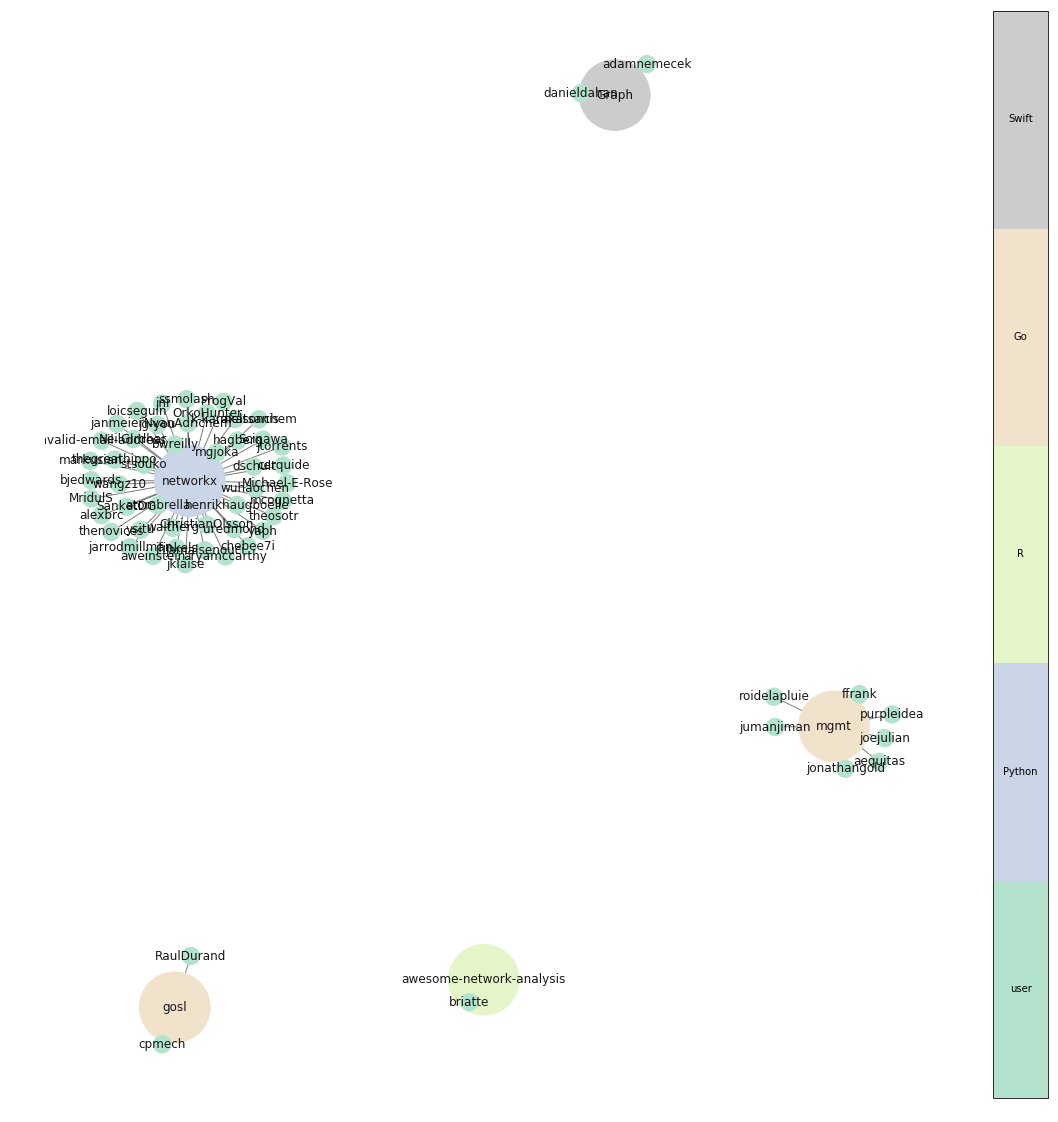

In [124]:
from itertools import  count
# set size
groups_type = set(nx.get_node_attributes(gtgraph,'node_type').values())
mapping_type = dict(zip(groups_type, [5000,300])) 
nodes = gtgraph.nodes()
size = [mapping_type[gtgraph.node[n]['node_type']] for n in nodes]

# set colors according to language
groups_lang = set(nx.get_node_attributes(gtgraph,'language').values())
mapping_lang = dict(zip(groups_lang, count()))
color = [mapping_lang[gtgraph.node[n]['language']] for n in nodes]

# draw nodes and edges separately 
fig = plt.figure(figsize = (20,20))
pos = nx.spring_layout(gtgraph)
ec = nx.draw_networkx_edges(gtgraph, pos, alpha=0.5)
nc = nx.draw_networkx_nodes(gtgraph, pos, nodelist=nodes, node_color=color, 
                            label=True, node_size=size, cmap=plt.cm.get_cmap('Pastel2', 5))
lc = nx.draw_networkx_labels(gtgraph, pos, alpha = 0.9)

# set colorbar
cbar = plt.colorbar(nc)
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['user','Python','R','Go', 'Swift']):
    cbar.ax.text(.5, (2 * j + 1) /10, lab, ha='center', va='center')


plt.axis('off')
plt.show()

#### Graph summary

Looks like the top 5 repos in the graph-theory topic forms  a sparse graph, with very little connectivity between the repositories. Also of note, is how these repositories are (with the exception of networkx) comprised by relatively fewer contributors when compared to the previous analysis with tensorflow and friends. This is as expected since neural networks have been in the limelight for the past few years, and is therefore not suprising that it is reflected  by the number of contributors to these projects. 

# Next steps

- Scale up to scrape a larger proportion of repository and contributor data (1 week)
    + Construct a Mysql database to manage node data
    + Deploy to AWS for cloud storage
- Cross-language collaboration - how often does this happen (within and outside of organisations) (1 - 2 days)
    + Find organisations within github, visualises how collaborative each organisation is with networkx 
    + Use connectivity algorithms to asses how much collaboration occurs within these organisations and make comparisons with non-organisation managed repositories (organic collaboration)
- Organisational structre: some laboratories have repositories, how do they compare with other types of organisations? ie. how interconnected are the contributors to other projects? (1-2 days)
    + Instead of comparing with non-organisation managed repositories, find and compare collaboration with laboratory managed repositories 
- What do large projects have in common? Is it possible to infer different styles of collaboration on the platform? (1 day)
    + collaboration in large projects, vs smaller projects, what is the nature of commits that non-core individuals make to these projects? 
- Develop a draft web app to visualise and host insights (1 week)

## Some improvements
- Maybe have weighted edges between users and repo based on number of contributions
- Plot in D3 instead of matplotlib to produce interactive graphs

## Top repos

- Do the top 10 repos (ranked by stars) interconnect?

In [10]:
#large projects and how they collaborate

ranked_repos = g.search_repositories('stars:>1000',sort = 'stars', order = 'desc')

In [11]:
for i in range(10):
    print(ranked_repos[i])

Repository(full_name="freeCodeCamp/freeCodeCamp")
Repository(full_name="twbs/bootstrap")
Repository(full_name="EbookFoundation/free-programming-books")
Repository(full_name="tensorflow/tensorflow")
Repository(full_name="facebook/react")
Repository(full_name="vuejs/vue")
Repository(full_name="sindresorhus/awesome")
Repository(full_name="getify/You-Dont-Know-JS")
Repository(full_name="d3/d3")
Repository(full_name="airbnb/javascript")


In [28]:
rankedgraph = nx.Graph() # initialise graph
for i in range(10):
    repo_to_network_2(ranked_repos[i], rankedgraph)

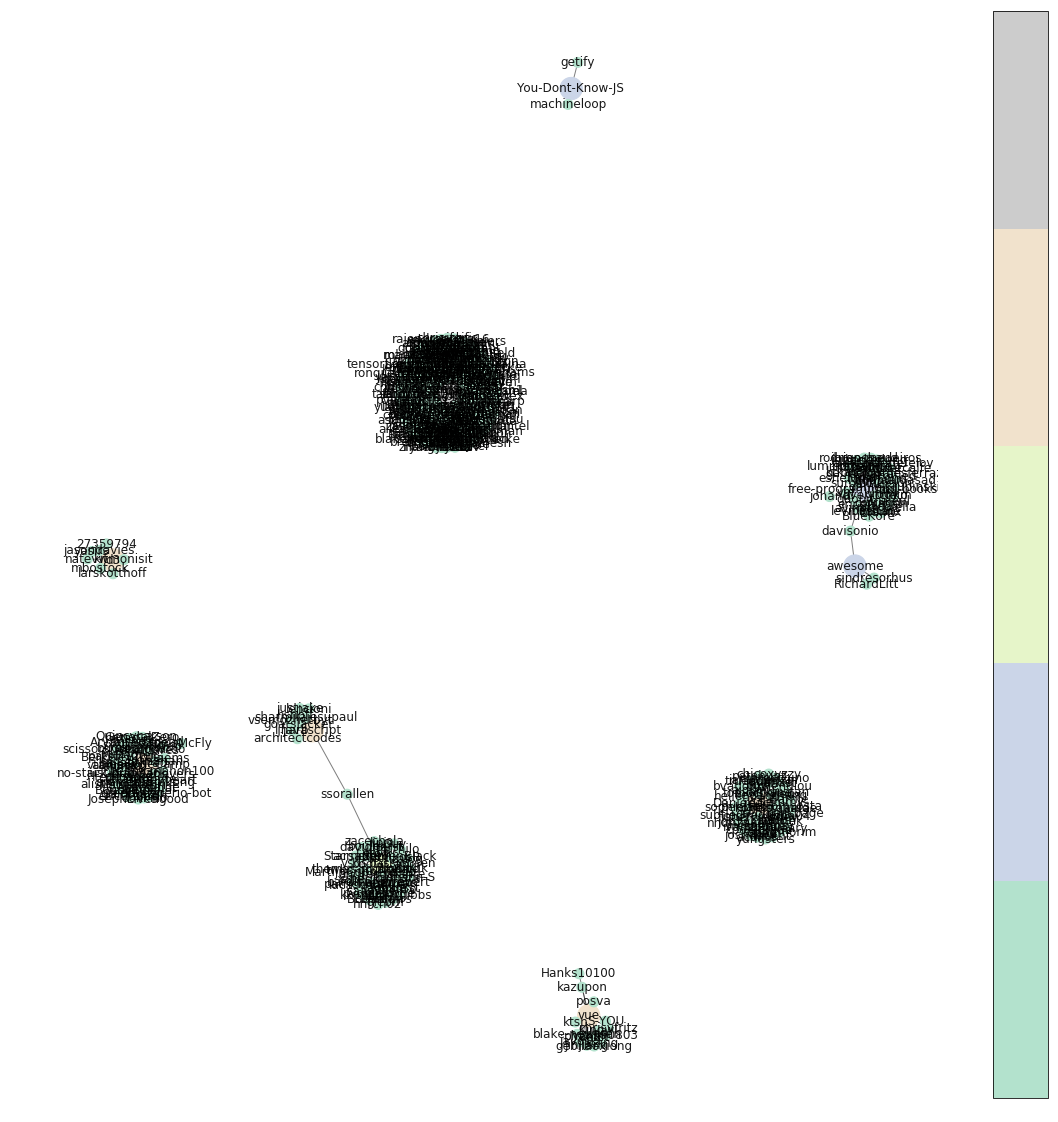

In [31]:
from itertools import  count
# set size
groups_type = set(nx.get_node_attributes(rankedgraph,'node_type').values())
mapping_type = dict(zip(groups_type, [100,500])) 
nodes = rankedgraph.nodes()
size = [mapping_type[rankedgraph.node[n]['node_type']] for n in nodes]

# set colors according to language
groups_lang = set(nx.get_node_attributes(rankedgraph,'language').values())
mapping_lang = dict(zip(groups_lang, count()))
color = [mapping_lang[rankedgraph.node[n]['language']] for n in nodes]

# draw nodes and edges separately 
fig = plt.figure(figsize = (20,20))
pos = nx.spring_layout(rankedgraph)
ec = nx.draw_networkx_edges(rankedgraph, pos, alpha=0.5)
nc = nx.draw_networkx_nodes(rankedgraph, pos, nodelist=nodes, node_color=color, 
                            label=True, node_size=size, cmap=plt.cm.get_cmap('Pastel2', 5))
lc = nx.draw_networkx_labels(rankedgraph, pos, alpha = 0.9)

# set colorbar
cbar = plt.colorbar(nc)
cbar.ax.get_yaxis().set_ticks([])
#for j, lab in enumerate(['user','Python','R','Go', 'Swift']):
#    cbar.ax.text(.5, (2 * j + 1) /10, lab, ha='center', va='center')


plt.axis('off')
plt.show()